# **Preprocessing pro max**

Since we it seems that the test set has something different than our trainning set, let's just apply A LOT of augmentation to ours, and see how it goes.

In [57]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_cv
import cv2
import tensorflow as tf
from keras_cv import layers as cv_layers
from tqdm import tqdm

In [3]:
dataset_filename = 'cleaned_training_set.npz'

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    directory_dataset = '/kaggle/input/blood-cells'
else:
    directory_dataset = '../data'
    if not os.path.exists(directory_dataset):
        os.makedirs(directory_dataset)
    if not os.path.exists(f'{directory_dataset}/{dataset_filename}'):
        url = "https://www.kaggle.com/datasets/camilosinning/blood-cells/download/d8yi67rTZ6HYsohjT9GN%2Fversions%2FFwagJNSFnqnnOYT5wDmO%2Ffiles%2Ftraining_set.npz?datasetVersionNumber=1"
        urllib.request.urlretrieve(url, directory_dataset)

In [4]:
dataset_path = f'{directory_dataset}/{dataset_filename}'

dataset = np.load(dataset_path,allow_pickle=True)
X = dataset['images']
y = dataset['labels']

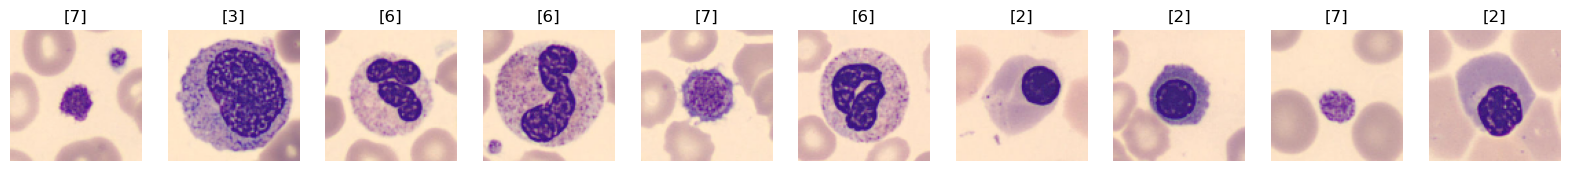

In [5]:
# See the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axes[i].imshow(X[i])
    axes[i].axis('off')
    axes[i].set_title(y[i])
plt.show()

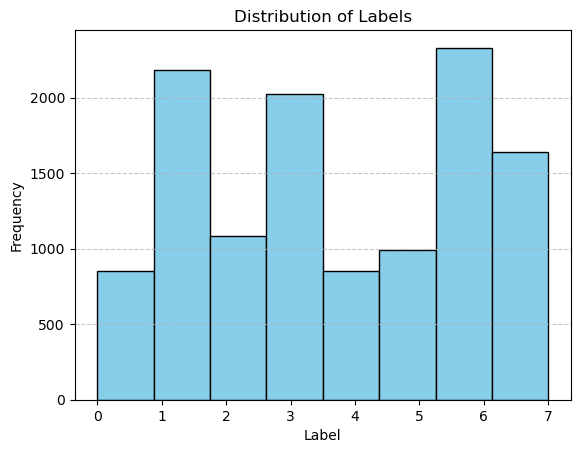

In [6]:
# Plot the distribution of the labels
plt.hist(y, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y)

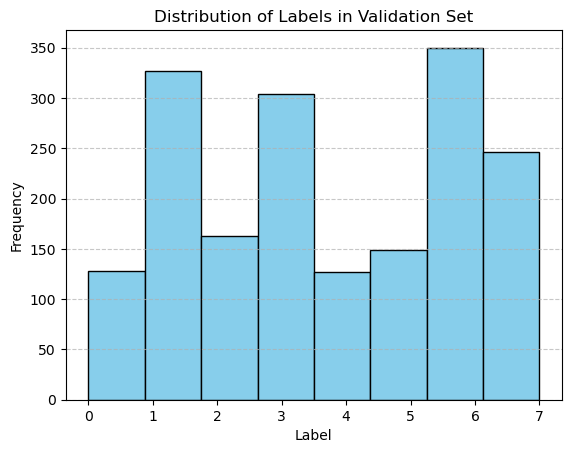

In [8]:
# Plot the distribution of the labels
plt.hist(y_val, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in Validation Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

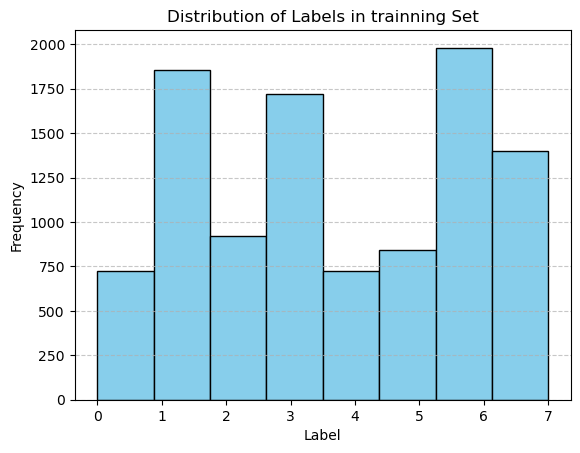

In [9]:
# Plot the distribution of the labels
plt.hist(y_train, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in trainning Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Augmentation

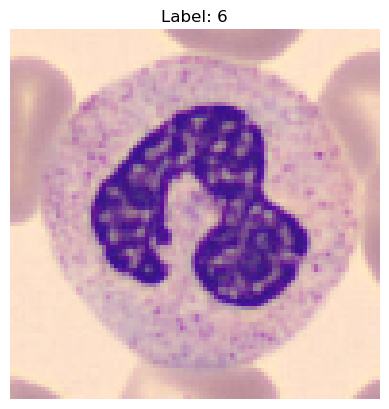

In [10]:
random_index = np.random.choice(len(X_train))
random_image = X_train[random_index]

plt.imshow(random_image)
plt.axis('off')
plt.title(f'Label: {y_train[random_index][0]}')
plt.show()

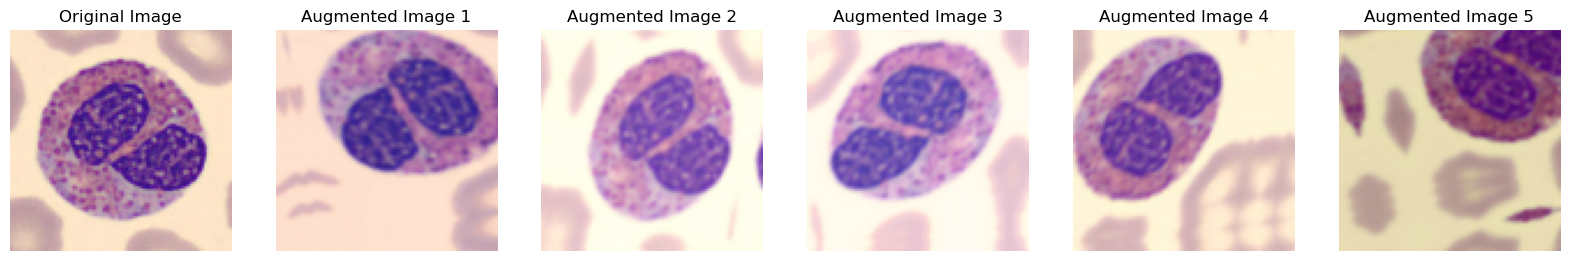

In [11]:
# Define the augmentation pipeline with color adjustments
data_augmentation = tf.keras.Sequential([
    cv_layers.RandomBrightness(factor=0.15),
    cv_layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    cv_layers.RandomFlip(mode="horizontal_and_vertical"),
    cv_layers.RandomRotation(factor=0.2),
    cv_layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    cv_layers.RandomShear(x_factor=0.2, y_factor=0.2),
    cv_layers.RandomHue(factor=0.1, value_range=(0, 255))
    
])

# Apply the transformations to a random image from the training set
random_index = np.random.choice(len(X_train))
random_image = X_train[random_index]

# Reshape the image to (1, height, width, channels) for the generator
random_image = random_image.reshape((1,) + random_image.shape)

# Generate multiple augmented images
num_augmented_images = 5
augmented_images = [data_augmentation(random_image) for _ in range(num_augmented_images)]

# Plot the original and augmented images
fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(20, 5))
axes[0].imshow(random_image[0])
axes[0].axis('off')
axes[0].set_title('Original Image')

for i in range(1, num_augmented_images + 1):
    augmented_image = augmented_images[i-1][0].numpy().astype('uint8')
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
    axes[i].set_title(f'Augmented Image {i}')

plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


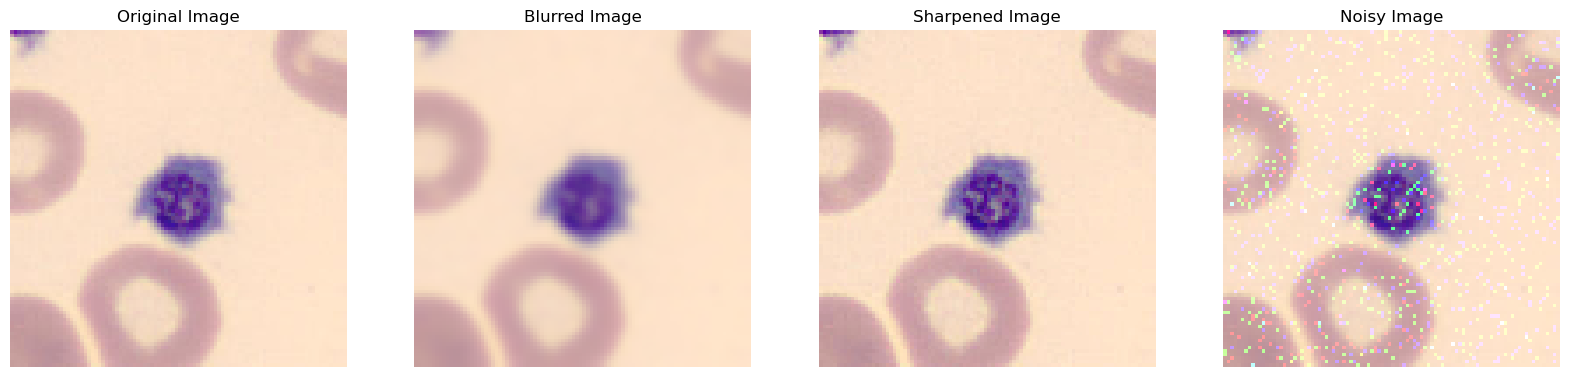

In [37]:
def apply_blur(image, ksize=(5, 5)):
    return cv2.GaussianBlur(image, ksize, 0)

def apply_sharpness(image, alpha=1.5, beta=-0.5):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def apply_noise(image, mean=0, std=0.6):
    noise = np.random.normal(mean, std, image.shape).astype('uint8')
    return cv2.add(image, noise)

# Apply the transformations to the random image
blurred_image = apply_blur(random_image[0])
sharpened_image = apply_sharpness(random_image[0])
noisy_image = apply_noise(random_image[0])

print(type(random_image[0]))
print(type(blurred_image))

# Plot the original and augmented images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(random_image[0])
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(blurred_image)
axes[1].axis('off')
axes[1].set_title('Blurred Image')

axes[2].imshow(sharpened_image)
axes[2].axis('off')
axes[2].set_title('Sharpened Image')

axes[3].imshow(noisy_image)
axes[3].axis('off')
axes[3].set_title('Noisy Image')

plt.show()

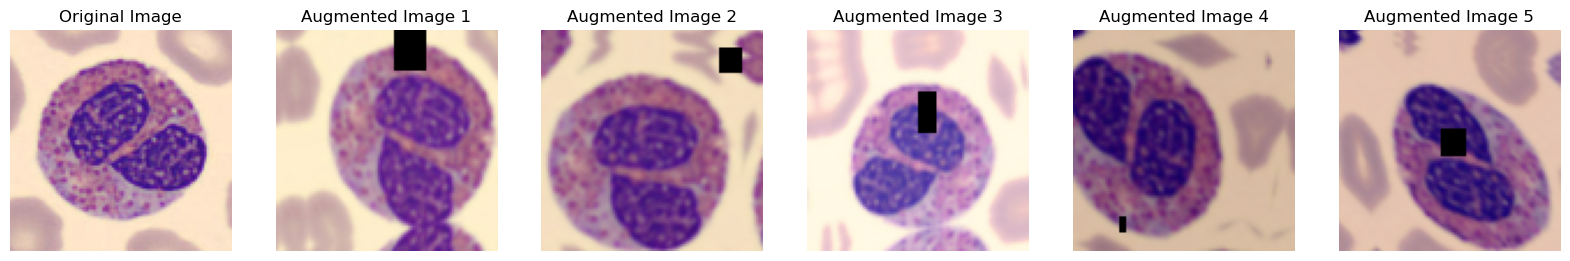

In [13]:
# Add RandomCutout to the augmentation pipeline
data_augmentation.add(cv_layers.RandomCutout(height_factor=0.2, width_factor=0.2))

# Apply the transformations to the same random image from the training set
# Reshape the image to (1, height, width, channels) for the generator
random_image = random_image.reshape((1,) + random_image.shape[1:])

# Generate multiple augmented images
num_augmented_images = 5
augmented_images = [data_augmentation(random_image) for _ in range(num_augmented_images)]

# Plot the original and augmented images
fig, axes = plt.subplots(1, num_augmented_images + 1, figsize=(20, 5))
axes[0].imshow(random_image[0])
axes[0].axis('off')
axes[0].set_title('Original Image')

for i in range(1, num_augmented_images + 1):
    augmented_image = augmented_images[i-1][0].numpy().astype('uint8')
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
    axes[i].set_title(f'Augmented Image {i}')

plt.show()


(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


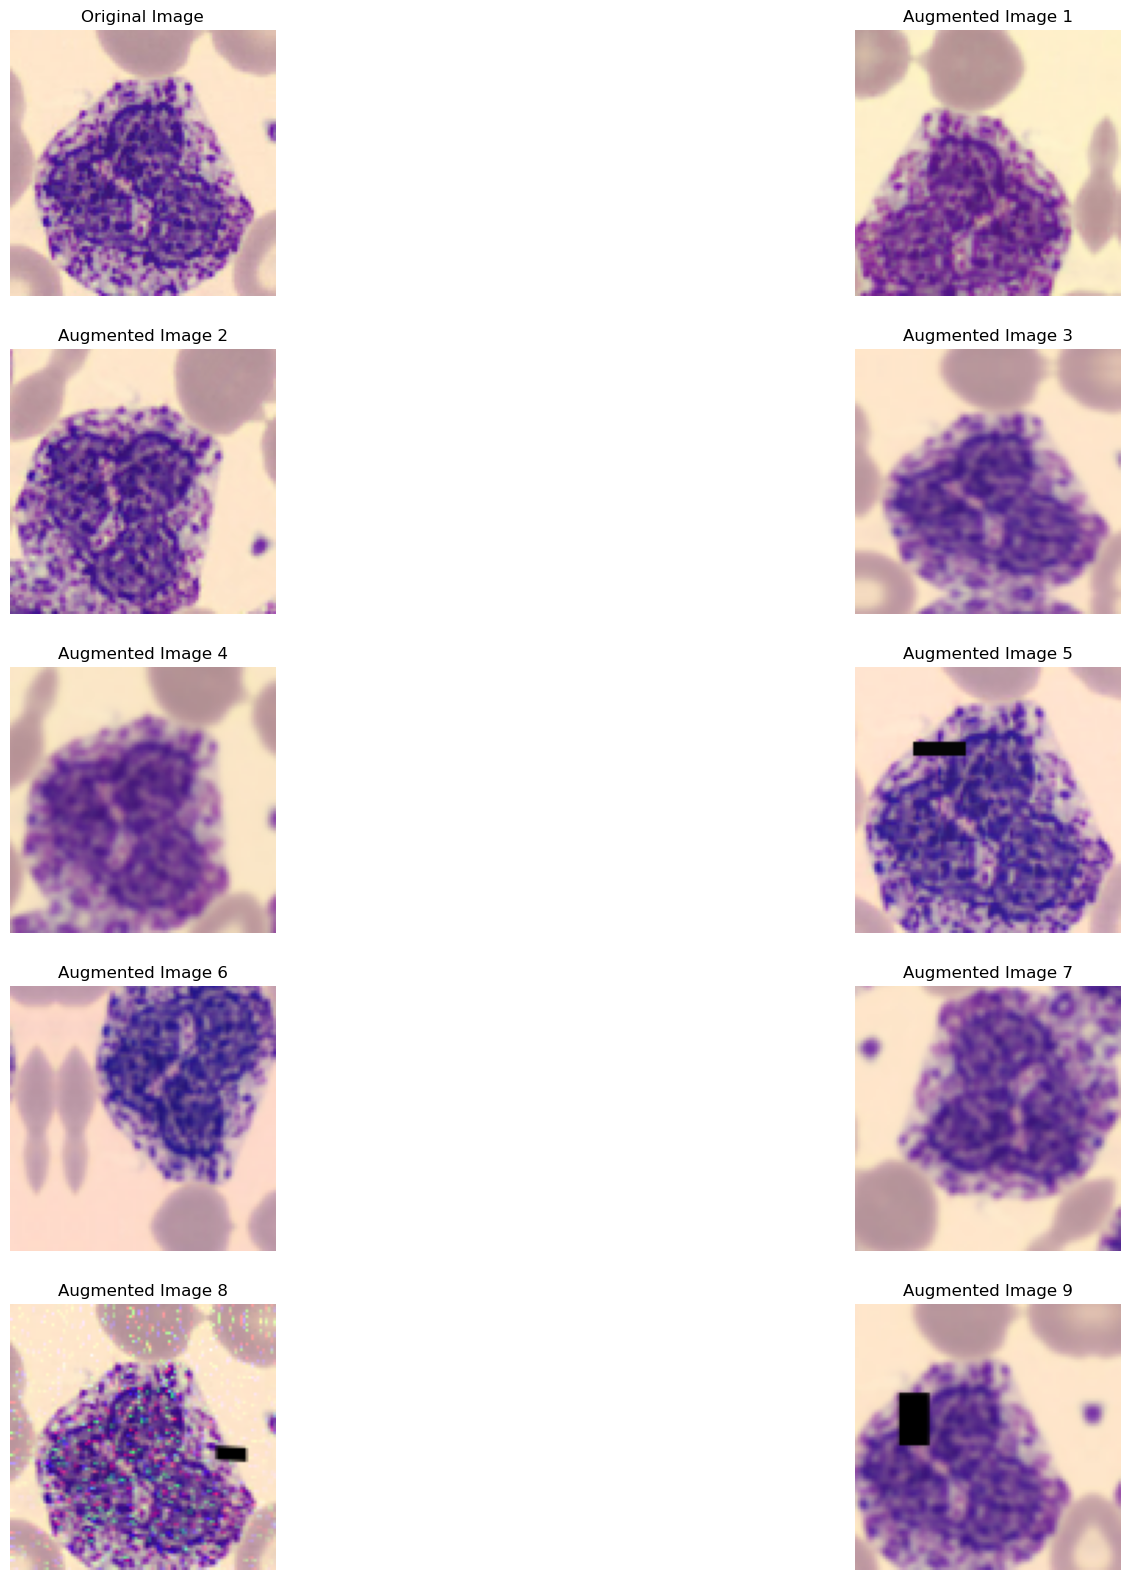

In [54]:
def generate_augmented_images(image, num_images=10, num_augmentations=4):
    augmented_images = []
    augmentation_choices = ['brightness', 'zoom', 'flip', 'rotation', 'translation', 'shear', 'hue', 'blur', 'sharpness', 'noise', 'cutout']

    for _ in range(num_images):
        augmented_image = image
        chosen_augmentations = np.random.choice(augmentation_choices, num_augmentations, replace=False)
        
        for augmentation_choice in chosen_augmentations:
            if augmentation_choice == 'blur':
                augmented_image = apply_blur(augmented_image[0])
            elif augmentation_choice == 'sharpness':
                augmented_image = apply_sharpness(augmented_image[0])
            elif augmentation_choice == 'noise':
                augmented_image = apply_noise(augmented_image[0])

            if augmentation_choice == 'blur' or augmentation_choice == 'sharpness' or augmentation_choice == 'noise':
                augmented_image = augmented_image.reshape((1,) + augmented_image.shape)
        
        # Apply the rest of the augmentations
        for augmentation_choice in chosen_augmentations:
            if augmentation_choice == 'brightness':
                augmented_image = cv_layers.RandomBrightness(factor=0.1)(augmented_image)
            elif augmentation_choice == 'zoom':
                augmented_image = cv_layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(augmented_image)
            elif augmentation_choice == 'flip':
                augmented_image = cv_layers.RandomFlip(mode="horizontal_and_vertical")(augmented_image)
            elif augmentation_choice == 'rotation':
                augmented_image = cv_layers.RandomRotation(factor=0.2)(augmented_image)
            elif augmentation_choice == 'translation':
                augmented_image = cv_layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(augmented_image)
            elif augmentation_choice == 'shear':
                augmented_image = cv_layers.RandomShear(x_factor=0.2, y_factor=0.2)(augmented_image)
            elif augmentation_choice == 'hue':
                augmented_image = cv_layers.RandomHue(factor=0.1, value_range=(0, 255))(augmented_image)
            elif augmentation_choice == 'cutout':
                augmented_image = cv_layers.RandomCutout(height_factor=0.2, width_factor=0.2)(augmented_image)
        
        augmented_images.append(augmented_image)

    return augmented_images

# Generate and plot 10 augmented images for a random image from the training set
random_index = np.random.choice(len(X_train))
random_image = X_train[random_index].reshape((1,) + X_train[random_index].shape)

augmented_images = generate_augmented_images(random_image)

fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes = axes.flatten()
axes[0].imshow(random_image[0])
axes[0].axis('off')
axes[0].set_title('Original Image')

# Ensure the number of augmented images does not exceed the number of subplots
num_images_to_plot = min(len(augmented_images), len(axes) - 1)

for i in range(1, num_images_to_plot + 1):
    augmented_image = augmented_images[i-1][0].numpy().astype('uint8') if isinstance(augmented_images[i-1], tf.Tensor) else augmented_images[i-1]
    print(augmented_image.shape)
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
    axes[i].set_title(f'Augmented Image {i}')

# Hide any remaining axes
for j in range(num_images_to_plot + 1, len(axes)):
    axes[j].axis('off')

plt.show()

In [58]:
# Count the occurrences of each class in the training set
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Identify the minority classes (e.g., classes with less than a threshold count)
threshold = np.percentile(counts, 25)  # You can adjust this threshold as needed
minority_classes = [cls for cls, count in class_counts.items() if count < threshold]

# Apply augmentation to the training set
augmented_X_train = []
augmented_y_train = []

for i in tqdm(range(len(X_train)), desc="Augmenting images"):
    image = X_train[i]
    label = y_train[i]
    
    # Apply more augmentations to minority classes
    if label in minority_classes:
        num_augmentations = 10  # Increase the number of augmentations for minority classes
    else:
        num_augmentations = 5  # Fewer augmentations for majority classes
    
    augmented_images = generate_augmented_images(image.reshape((1,) + image.shape), num_images=num_augmentations)
    
    for aug_image in augmented_images:
        augmented_X_train.append(aug_image[0].numpy().astype('uint8') if isinstance(aug_image, tf.Tensor) else aug_image)
        augmented_y_train.append(label)

# Convert the augmented data back to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

print(f'Original training set size: {len(X_train)}')
print(f'Augmented training set size: {len(augmented_X_train)}')

Augmenting images: 100%|██████████| 10165/10165 [39:43<00:00,  4.27it/s] 


Original training set size: 10165
Augmented training set size: 58055


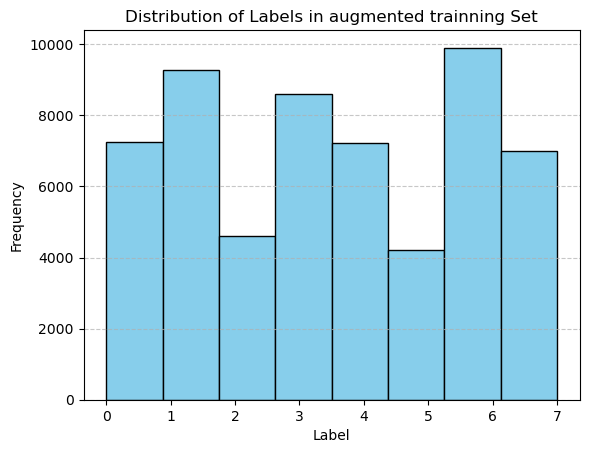

In [62]:
# Plot the distribution of the labels
plt.hist(augmented_y_train, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in augmented trainning Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Save the balanced dataset
np.savez_compressed(f'{directory_dataset}/train_aug_cleaned_training_set.npz', images=augmented_X_train, labels=augmented_y_train)

print(f"Balanced dataset saved to {directory_dataset}/tain_aug_cleaned_training_set.npz")

Balanced dataset saved to ../data/tain_aug_balanced_cleaned_training_set.npz


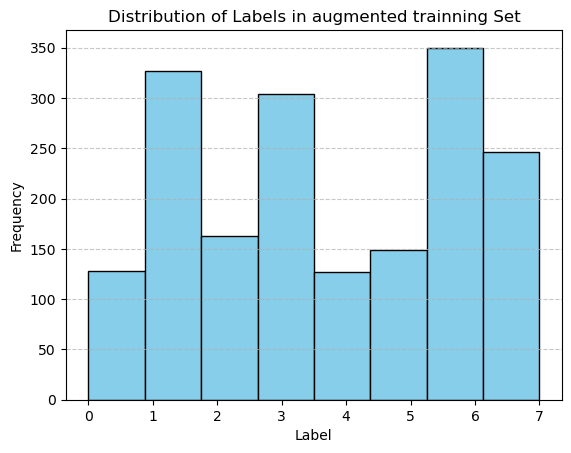

In [65]:
# Plot the distribution of the labels
plt.hist(y_val, bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in augmented trainning Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Save the balanced dataset
np.savez_compressed(f'{directory_dataset}/val_cleaned_training_set.npz', images=X_val, labels=y_val)

print(f"Balanced dataset saved to {directory_dataset}/val_cleaned_training_set.npz")

Balanced dataset saved to ../data/val_balanced_cleaned_training_set.npz
